In [3]:
import numpy as np
import matplotlib.pyplot as plt

def read_file():
    # Вариант 4
    path = "data.txt"
    with open(path, 'r',encoding='windows-1251') as f:
        content = f.read().split('\n\n')[3].split('\n')[-1]
        content = list(map(np.float32, content.split(',')))
        return pd.Series(content)

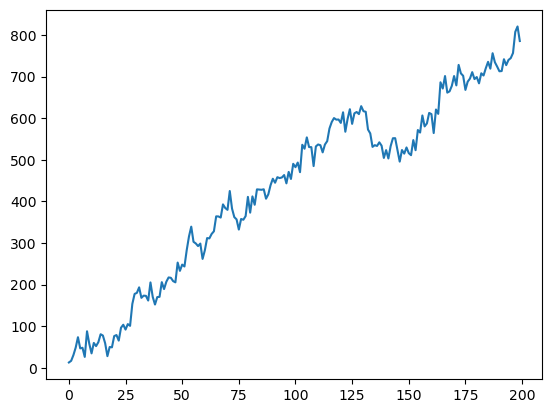

In [4]:
data = read_file()
plt.plot(data)
plt.show()

In [5]:

# Определение типа наблюдаемого ряда с помощью процедуры Доладо-Дженкинса-Сосвилла-Риверо
from statsmodels.tsa.stattools import adfuller
print(adfuller(data))

(-0.9151237990083259, 0.7829511422299741, 9, 190, {'1%': -3.4652439354133255, '5%': -2.8768752281673717, '10%': -2.574944653739612}, 1670.6861256267778)


0.941940638406074


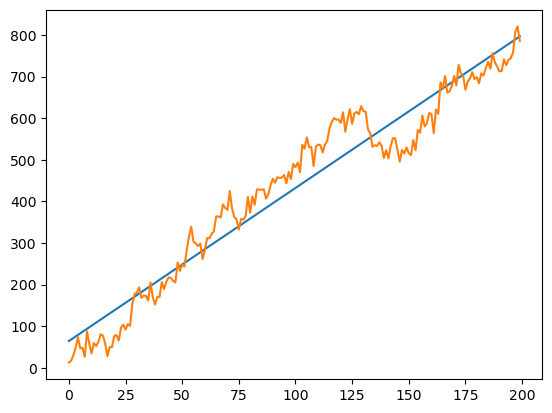

In [6]:

# Оценка по МНК детерминированной составляющей ряда
x = np.arange(0, 200)
y = data

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
lr = LinearRegression()
lr.fit(x.reshape(-1, 1), y)
preds_linear = lr.predict(x.reshape(-1, 1))

print(r2_score(y, preds_linear))
plt.plot(preds_linear)
plt.plot(y)
plt.show()

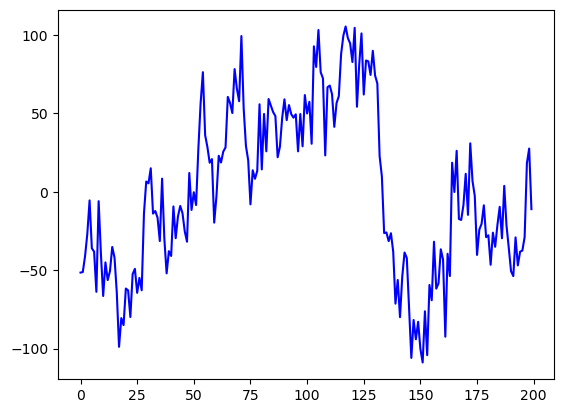

In [7]:

# Удаление тренда из ряда

residuals = y - preds_linear
plt.plot(residuals, color='blue')
plt.show()

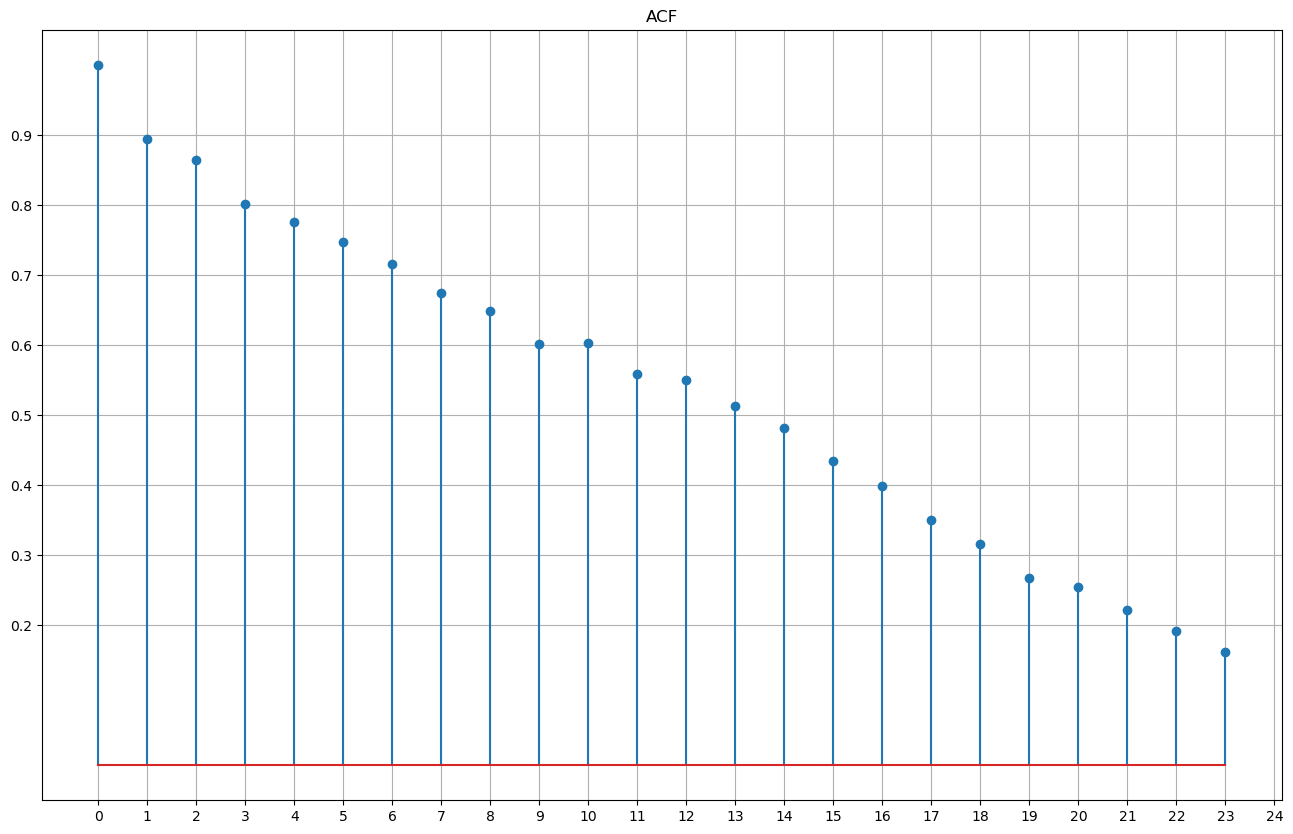

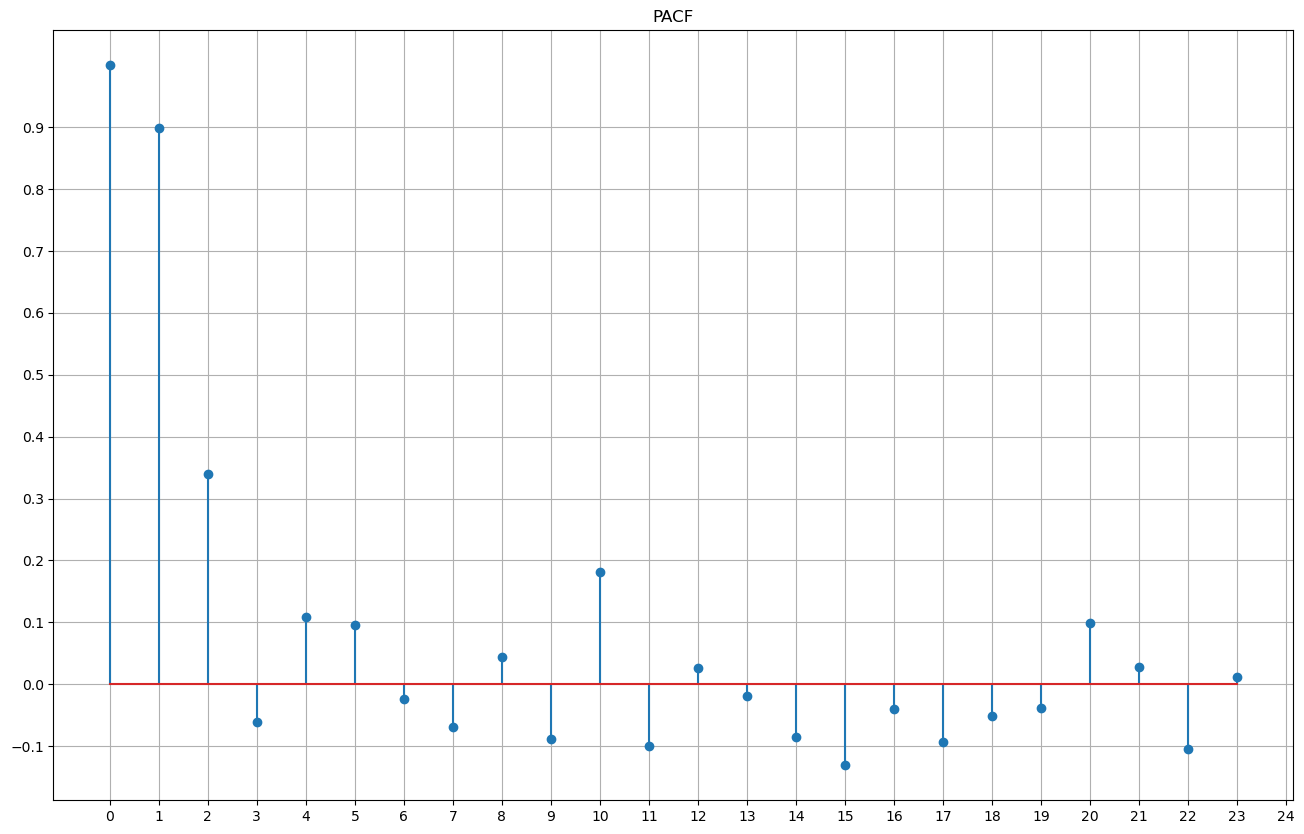

In [8]:


# Проведение идентификации случайной составляющей ряда
# строим ACF, PACF
from statsmodels.tsa.stattools import acf, pacf

acf_data = acf(residuals)

plt.figure(figsize=(16, 10))
plt.xticks(np.arange(0, 25, 1))
plt.yticks(np.arange(round(acf_data.min(), 1), round(acf_data.max(), 1), 0.1))
plt.grid()
plt.stem(acf_data)
plt.title('ACF')
plt.show()

pacf_data = pacf(residuals)
plt.figure(figsize=(16, 10))
plt.xticks(np.arange(0, 25, 1))
plt.yticks(np.arange(round(pacf_data.min(), 1), round(pacf_data.max(), 1), 0.1))
plt.grid()
plt.title('PACF')
plt.stem(pacf_data)
plt.show()

In [9]:

# Оценка параметров выбранных моделей

from statsmodels.tsa.arima.model import ARIMA
modelAR = ARIMA(residuals, order=(3,0,0)).fit() # AR 3
modelMA = ARIMA(residuals, order=(0,0,25)).fit() # MA 25

# коэффициенты AR
modelAR.summary()
# коэффициенты MA
modelMA.summary()
# Выбор модели с помощью критериев Акаике и Шварца

print(modelAR.aic, 'Акаике')
print(modelAR.bic, 'Шварца')
print(modelMA.aic, 'Акаике')
print(modelMA.bic, 'Шварца')

/Users/daniil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1815.0692487557772 Акаике
1831.5608355885174 Шварца
1834.1605045568544 Акаике
1923.2150734536515 Шварца


In [10]:
# Диагностика остатков

from statsmodels.stats.diagnostic import acorr_ljungbox as lb
import pandas as pd
lb(modelAR.resid, lags=20)

,lb_stat,lb_pvalue
1,0.009724,0.921446
2,0.167396,0.919709
3,2.518092,0.472030
4,2.735424,0.603030
5,3.957009,0.555622
6,4.395111,0.623369
7,4.422533,0.730024
8,4.487758,0.810657
9,9.131706,0.425207
10,13.443451,0.199923


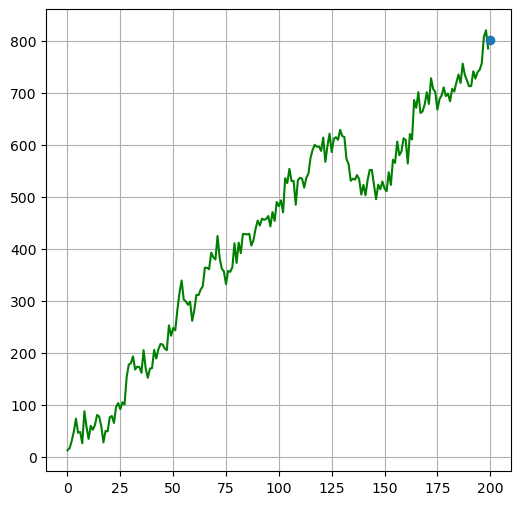

In [11]:

# Построение прогноза
plt.figure(figsize=(6, 6))
pred_next = modelAR.predict(200) + lr.predict(np.array([200]).reshape(1, -1))[0]

plt.grid()
plt.plot(data, color='green'),
plt.plot(200, pred_next, 'o')
plt.show()

In [12]:
# Удаление тренда из ряда разностным оператором
# import statsmodels
# preds = statsmodels.tsa.statespace.tools.diff(data)
# print(lb(preds, lags=20))
# plt.plot(preds)